In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# get data from https://drive.google.com/file/d/1GqHXiTMdWfNniUfF0B5TkKnvMSV1kI4b/edit
# obtain from https://finance.yahoo.com/quote/BTC-USD/history/
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1GqHXiTMdWfNniUfF0B5TkKnvMSV1kI4b'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('BTC-USD.csv')

# create data frame
data = pd.read_csv('BTC-USD.csv')

[Text(0, 0, '2014-09-17'),
 Text(0, 0, '2015-04-05'),
 Text(0, 0, '2015-10-22'),
 Text(0, 0, '2016-05-09'),
 Text(0, 0, '2016-11-25'),
 Text(0, 0, '2017-06-13'),
 Text(0, 0, '2017-12-30'),
 Text(0, 0, '2018-07-18'),
 Text(0, 0, '2019-02-03'),
 Text(0, 0, '2019-08-22'),
 Text(0, 0, '2020-03-09'),
 Text(0, 0, '2020-09-25'),
 Text(0, 0, '2021-04-13')]

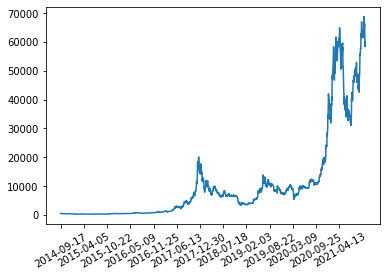

In [7]:
# graph bitcoin vs days
import matplotlib.pyplot as plt
import seaborn as sns # Used for plotting

g = sns.lineplot(x = np.linspace(1,2622,2622), y = data['High'].values.reshape(-1))
g.set(xticks=np.arange(0,2500,200))
g.set_xticklabels(rotation=30, labels = data['Date'][0::200])

### 1) Preprocessing Data

In [8]:
# preprocess data for a recurrent neural netowrk 
# only uses the High column of the data set 
data_high = data.High.values
data_high = data_high.astype(np.float32)

# remove missing values 
data_high = data_high[~np.isnan(data_high)]

# rescale data to [0,1]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
data_normalized = scaler.fit_transform(data_high.reshape(-1,1))

# augment the data so that "time_steps" number of previous days are fed to the model at the current time step in order to form a prediction
def create_dataset(dataset, time_steps=1):
    """
    Generate a dataset where the time series X[n] contains the readings for the 'time_step' previous days 
    and y contains the price for today.
    args:
    dataset: numpy array, the data
    time_steps: the number of previous days to feed to RNN

    returns:
    tuple: a dataset with x[i] containing 'time_step' number of previous prices, target price for x[i]
    """
    dataX, dataY = [],[]
    for i in range(len(dataset)-time_steps-1):
        a = dataset[i:(i+time_steps)]
        dataX.append(a)
        dataY.append(dataset[i + time_steps])
    return np.array(dataX), np.array(dataY)

# create a dataset based on number of days the model could look back
time_steps = 4
X, y = create_dataset(data_normalized, time_steps)

### 2) Data Partitioning

In [9]:
# split data into train and test sets 
# 80% for training and 20% for test 
train_size =int(len(data_normalized) * 0.8)
test_size = len(data_normalized) - train_size
train, test = data_normalized[0: train_size,:], data_normalized[train_size: len(data_normalized),:]

X_train, y_train = create_dataset(train, time_steps)
X_test, y_test = create_dataset(test, time_steps)

# reshape input to be [samples, time steps, features].
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

### 3) RNN Model

Epoch 1/30
1671/1671 - 7s - loss: 1.5195e-04 - mean_squared_error: 1.5195e-04 - val_loss: 4.4638e-05 - val_mean_squared_error: 4.4638e-05 - 7s/epoch - 4ms/step
Epoch 2/30
1671/1671 - 5s - loss: 3.6739e-05 - mean_squared_error: 3.6739e-05 - val_loss: 4.2919e-05 - val_mean_squared_error: 4.2919e-05 - 5s/epoch - 3ms/step
Epoch 3/30
1671/1671 - 7s - loss: 3.3782e-05 - mean_squared_error: 3.3782e-05 - val_loss: 6.3809e-05 - val_mean_squared_error: 6.3809e-05 - 7s/epoch - 4ms/step
Epoch 4/30
1671/1671 - 4s - loss: 3.0812e-05 - mean_squared_error: 3.0812e-05 - val_loss: 4.5322e-05 - val_mean_squared_error: 4.5322e-05 - 4s/epoch - 2ms/step
Epoch 5/30
1671/1671 - 4s - loss: 3.0075e-05 - mean_squared_error: 3.0075e-05 - val_loss: 4.2341e-05 - val_mean_squared_error: 4.2341e-05 - 4s/epoch - 2ms/step
Epoch 6/30
1671/1671 - 3s - loss: 2.8450e-05 - mean_squared_error: 2.8450e-05 - val_loss: 1.1190e-04 - val_mean_squared_error: 1.1190e-04 - 3s/epoch - 2ms/step
Epoch 7/30
1671/1671 - 4s - loss: 2.8988

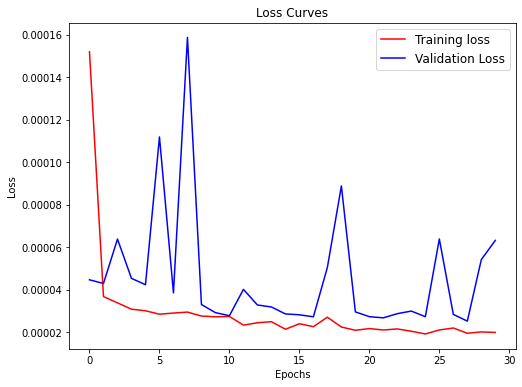

In [10]:
loss = 'mean_squared_error'
opt = 'adam'
metrics = 'mean_squared_error'
batchsize = 1
epochs =  30

model = Sequential()
model.add(LSTM(50, input_shape=((1,time_steps))))
model.add(Dense(1))
model.compile(loss=loss, optimizer=opt,metrics=[metrics])

# Fit model
history =  model.fit(X_train, 
                 y_train,
                 epochs = epochs,
                 batch_size = batchsize,
                 verbose = 2,
                 validation_split=0.2)

# Plot model
def plot_losses(hist):
  plt.figure(figsize=[8,6])
  plt.plot(hist.history['loss'],'r',)
  plt.plot(hist.history['val_loss'],'b',)
  plt.legend(['Training loss', 'Validation Loss'],fontsize=12)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss Curves')

plot_losses(history)

### 4) Looking at the Prediction

66/66 [==============================] - 0s 2ms/step
mse: 0.003637135


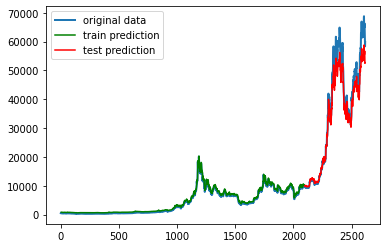

In [12]:
testPredict = model.predict(X_test)
trainPredict = model.predict(X_train)
print("mse: " + str(mean_squared_error(y_test, testPredict)))

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(y_test)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(data_normalized)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_steps: len(trainPredict) + time_steps, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(data_normalized)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + time_steps*2 + 1: len(data_normalized) - 1, :] = testPredict


plt.plot(scaler.inverse_transform(data_normalized), linewidth=2)
plt.plot(trainPredictPlot, 'g')
plt.plot(testPredictPlot, 'r')
plt.legend(["original data", "train prediction", "test prediction"])
plt.show()